## Fuentes
* Este contenido fue tomado del curso MINF4538 Big Data Analysis - University of Zurich <a href=https://lms.uzh.ch/auth/RepositoryEntry/16703094861>Big Data Analytics</a> y el uso fue autorizado por el profesor Sven Helmer

* Adaptaciones menores hechas para nuestro curso.

# End-to-End Example

In this practical exercise, we are going to play through all the stages of a data-analytics process using a data set about the NBA (National Basketball Association). (We are taking a shortcut when it comes to collecting the data, as the web provider would probably not like it if around 80 students scrape data off their web site.) The questions we would like to answer are the following:

1. How has the total amount of 3-point attempts by players in the NBA evolved compared to the number of (regular) 2-point attempts? The 3-point line was introduced in the 1979/80 season.

2. How will 3-point attempts evolve in the (near) future if the current trends continue?



## Collecting the Data

So, the data is provided in a file called season_totals.csv. Nevertheless, below you find the code that can be used to scrape the data, so you have an impression what this looks like. The data is taken from https://www.basketball-reference.com/

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
def parse_html_table(html_table):
  '''For parsing basketball reference stats html table.
  We will apply this function to every seasons html page.'''
  data = []
  cur_row = []
  col_names = []

  for ele in html_table:
    stat_name = ele['data-stat']
    stat_value = ele.string
    new_row = (stat_name == 'player')
    if new_row:
      if cur_row:
        data.append(cur_row)
      cur_row = []
      col_names = []
      cur_row.append(ele['csk']) # fixes weird asterisk error
      col_names.append(stat_name)
      col_names.append('player_id')
      cur_row.append(ele['data-append-csv'])
      continue

    cur_row.append(stat_value)
    col_names.append(stat_name)
  return data, col_names

# Loop over each year and collect data
dfs = []
for yr in range(1980,(2017 + 1)):
  url = '.../{yr}.html'.format(yr = yr)
  r = requests.get(url)
  soup = BeautifulSoup(r.text, 'html.parser')
  yr_data, col_names = parse_html_table(soup.findAll('td'))
  df = pd.DataFrame(yr_data, columns = col_names)
  df['yr'] = yr
  dfs.append(df)

#all_seasons = pd.concat(dfs)
#all_seasons.to_csv('season_totals.csv')



Just upload the file using the standard dialog. This contains information about every player in the seasons from 1980 until 2017. The file season_totals.csv contains the following attributes:

Column Name    Description <br>
_c0    row number <br>
player    Player Name (not an ID) <br>
player_id    Unique player identification. <br>
pos    Player position: PG (Point Guard),SG (Shooting Guard),SF (Small Forward),PF (Power Forward),C (Center) <br>
age    Age of Player at the start of February 1st of that season. <br>
team_id    Team id <br>
g    Games played in season. <br>
gs    Games started (played from beginning, no exchange) in season. <br>
mp    Minutes played in season. <br>
fg    Field goals in season. <br>
fga    Field goal attempts in season. <br>
fg_pct    Field goal percentage in season. <br>
fg3    3-Point field goals in season. <br>
fg3a    3-Point field goal attempts in season. <br>
fg3_pct    3-Point field goal percentage in season. <br>
fg2    2-Point field goals in season. <br>
fg2a    2-point field goal attempts in season. <br>
fg2_pct    2-Point field goal percentage in season. <br>
efg_pct    Effective field goal percentage in season. <br>
ft    free throws in season. <br>
fta    Free throw attempts in season. <br>
ft_pct    Free throw percentage in season. <br>
orb    Offensive rebounds in season. <br>
drb    Defensive rebounds in season. <br>
trb    Total rebounds in season. <br>
ast    Assists in season. <br>
stl    Steals in season. <br>
blk    Blocks in season. <br>
tov    Turnovers in season. <br>
pf    Personal fouls in season. <br>
pts    Points in season. <br>
yr    Year of season; i.e. 1980 refers to season 1979-80





In [ ]:
from google.colab import files
uploaded = files.upload()

Let's have a first look if the file uploaded successfully by checking the first couple of lines.

In [1]:
!ls
!head season_totals.csv

endtoend.ipynb    season_totals.csv
,player,player_id,pos,age,team_id,g,gs,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,fg2,fg2a,fg2_pct,efg_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,yr
0,"Abdul-Jabbar,Kareem",abdulka01,C,32,LAL,82,,3143,835,1383,.604,0,1,.000,835,1382,.604,.604,364,476,.765,190,696,886,371,81,280,297,216,2034,1980
1,"Abernethy,Tom",abernto01,PF,25,GSW,67,,1222,153,318,.481,0,1,.000,153,317,.483,.481,56,82,.683,62,129,191,87,35,12,39,118,362,1980
2,"Adams,Alvan",adamsal01,C,25,PHO,75,,2168,465,875,.531,0,2,.000,465,873,.533,.531,188,236,.797,158,451,609,322,108,55,218,237,1118,1980
3,"Archibald,Tiny",architi01,PG,31,BOS,80,80,2864,383,794,.482,4,18,.222,379,776,.488,.485,361,435,.830,59,138,197,671,106,10,242,218,1131,1980
4,"Awtrey,Dennis",awtrede01,C,31,CHI,26,,560,27,60,.450,0,0,,27,60,.450,.450,32,50,.640,29,86,115,40,12,15,27,66,86,1980
5,"Bailey,Gus",bailegu01,SG,28,WSB,20,,180,16,35,.457,1,1,1.000,15,34,.441,.471,5,13,.385,6,22,28,26,7,4,11,18,38,1980
6,"Bailey,

Then we load some standard libraries we need for processing and visualizing the data (and also configure the style for seaborn).

In [2]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("white")

## Exploring/Processing/Cleaning the Data

Now we are set to start exploring the data. For some of the exploration, we also need to process the data (e.g. counting the total number entries, finding the maximal number of points scored by a player during one season, summing up the total number of games of Michael Jordan).

Then we also want to find the top ten scorers (i.e., the players who scored the most points over their whole NBA career)

In [3]:
data = pd.read_csv('season_totals.csv', index_col=0)

print(data['player_id'].count())  # number of total entries
print(data['pts'].max())          # max of pts
print(data['g'][data['player_id'] == 'jordami01'].sum())   # number of games of Michael Jordan

pointsperplayer = data.groupby(['player'])['pts'].sum()
print(pointsperplayer.sort_values(ascending=False).head(10))



18889
3041
1072
player
Malone,Karl          36928
Bryant,Kobe          33643
Jordan,Michael       32292
Nowitzki,Dirk        30260
Johnson,Eddie        29779
O'Neal,Shaquille     29428
James,LeBron         28787
Wilkins,Dominique    28591
Carter,Vince         27463
Iverson,Allen        27457
Name: pts, dtype: int64


While the previous section only returned some numbers, it may also be interesting to visualize some of the data. Below you find some examples in which we use histograms to collect and visualize some statistics about field goals and the age of players. If the domain is rather small (here the age of the players), dividing the histogram up into a fixed number of bins may produce some misleading results (like the two peaks). Alternatively, we can define the boundaries of the bins.

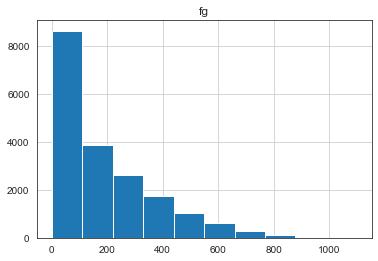

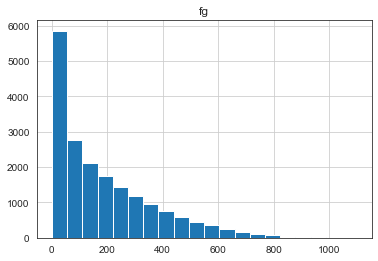

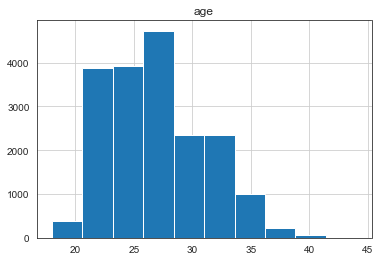

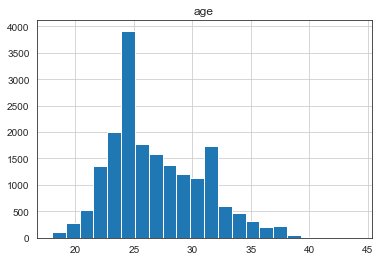

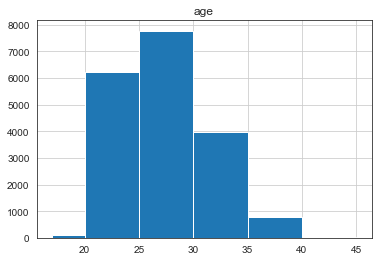

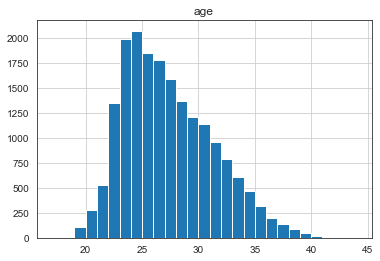

In [4]:
histogram = data.hist(column='fg')
histogram = data.hist(column='fg', bins=20)
histogram = data.hist(column='age')
histogram = data.hist(column='age', bins=22)
histogram = data.hist(column='age', bins=[17,20,25,30,35,40,45])
histogram = data.hist(column='age', bins=range(17,45))

Next, let us look at how successful players were in converting attempt into actual points.

In [ ]:
fieldgoals = data.groupby(['yr']).agg({'fg': sum, 'fga': sum})
fieldgoals['ratio'] = fieldgoals['fg'] / fieldgoals['fga']

print(fieldgoals.sort_values(by=['ratio'],ascending=False).head(10))
print(fieldgoals.sort_values(by=['yr'],ascending=True))

As columns of numbers are not easy to interpret, we are going to plot the data next. Looking at the total number of field goals and field goal attempts over the seasons from 1980 to 2017, we see two distinctive drops (which do not seem to show up in the ratio). This is probably some kind of artifcact: can you explain what happened here? Can this part of the data be cleaned or do we have to live with it?

In [ ]:
ax = fieldgoals.plot(y='fg')
fieldgoals.plot(y='fga', ax=ax)
fieldgoals.plot(y='ratio')


Let us now turn towards answering the questions formulated at the beginning of the notebooks, i.e., we will investigate the 3-point attempts compared to the 2-point attempts.

In [ ]:
fieldgoals = data.groupby(['yr']).agg({'fg2a': sum, 'fg3a': sum})
print(fieldgoals.head(10))

Let's look at a graphical representation. Again we see the two drops, but then there is also a rise in the number of 3-point attempts in the late 1990s. Is this a statistical fluke or is there some explanation for it?

In [ ]:
ax = fieldgoals.plot(y='fg2a')
fieldgoals.plot(y='fg3a', ax=ax)

## Building a Model and Visualizing the Results

Next we build a model to describe the evolution of 3-point attempts in the NBA. For this we have to do a bit of preprocessing to get the data into the right shape. Then we train a linear regression model.

In [ ]:
x = fieldgoals.index.values
y = fieldgoals['fg3a'].values

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(1980, 2017, 100)
yfit = model.predict(xfit[:, np.newaxis])

lindf = pd.DataFrame(index=xfit, data={'3pt_attempts': yfit})
ax = fieldgoals.plot(y='fg3a')
lindf.plot(y='3pt_attempts', ax=ax)


There seems to be a steeper rise in 3-point attempts in the later part of the time period. Let's see what a model for the years from 2009 to 2017 looks like.

In [ ]:
recentx = x[29:38, np.newaxis]
recenty = y[29:38]

model.fit(recentx, recenty)

rxfit = np.linspace(2009, 2017, 30)
ryfit = model.predict(rxfit[:, np.newaxis])

rlindf = pd.DataFrame(index=rxfit, data={'3pt_attempts': ryfit})
ax = fieldgoals.plot(y='fg3a')
lindf.plot(y='3pt_attempts', ax=ax)
rlindf.plot(y='3pt_attempts', ax=ax)

# If you are finished...

...with all the analysis of the 3-point attempts and you think you have played around with the long enough, here are some more concrete questions to answer:

1. How did the number of games and the number of personal fouls evolve over the seasons? Is there a correlation between the two numbers?

2. What does this mean for individual players? Have players committed more or fewer personal fouls? Is this correlated to the time they spent on the basketball court?

This is a free-form exercise, so no code is provided. Use and re-use code snippets you have used for analyzing the 3-point attempts and/or google for functionality you need.